In [1]:
import missingno as msno
import pandas as pd
import seaborn as sns
from sklearn.metrics import mutual_info_score

In [2]:
# !cp /Users/bajajn/Downloads/healthcare-dataset-stroke-data.csv /Users/bajajn/zoomcampML/mlbookzoomcamp-midterm-stroke-prediction

In [3]:
# Reading the dataset
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
# Id column and target

id = 'id'
target = 'stroke'

In [5]:
# Describing the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [6]:
# Lets make columns consistent, all lower case and underscores if any spaces

columns = [cols.lower().replace(" ","_") for cols in data]
data.columns = columns
print(data.columns)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [7]:
# We can also see some columns have 1 and 0 as yes or no, where as others don't, lets clean that up
data['ever_married'] = data['ever_married'].apply(lambda val: 1 if val == 'Yes' else 0)

In [8]:
# We can see that data points have some capital in them and some hashes and some spaces

cat_columns = [cols for cols in data if data[cols].dtype == 'object' or data[cols].nunique() <= 5]
cat_columns = [cols for cols in cat_columns if cols != target]

In [9]:
def clean_strings(val):
    """Function to make data values consistent"""

    return val.replace(" ","_").replace("-", "_")

# Lets make the values consistent
for col in cat_columns:
    if data[col].dtype == 'object':
        data[col] = data[col].apply(lambda val: val.lower())
        data[col] = data[col].apply(lambda val: clean_strings(val))

In [10]:
# Lets check if data values are consistent
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,male,67.0,0,1,1,private,urban,228.69,36.6,formerly_smoked,1
1,51676,female,61.0,0,0,1,self_employed,rural,202.21,NaN,never_smoked,1
2,31112,male,80.0,0,1,1,private,rural,105.92,32.5,never_smoked,1
3,60182,female,49.0,0,0,1,private,urban,171.23,34.4,smokes,1
4,1665,female,79.0,1,0,1,self_employed,rural,174.12,24.0,never_smoked,1


In [11]:
# Lets check the cardinality of categorical columns
for cols in cat_columns:
    print(cols)
    print(data[cols].value_counts())
    print()


gender
female    2994
male      2115
other        1
Name: gender, dtype: int64

hypertension
0    4612
1     498
Name: hypertension, dtype: int64

heart_disease
0    4834
1     276
Name: heart_disease, dtype: int64

ever_married
1    3353
0    1757
Name: ever_married, dtype: int64

work_type
private          2925
self_employed     819
children          687
govt_job          657
never_worked       22
Name: work_type, dtype: int64

residence_type
urban    2596
rural    2514
Name: residence_type, dtype: int64

smoking_status
never_smoked       1892
unknown            1544
formerly_smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [12]:
# Lets check missing values across the dataset
missing_values = data.isnull().mean()
print("Percentage of missing values for each column")
print(round(missing_values*100,2))

Percentage of missing values for each column
id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64


<AxesSubplot: >

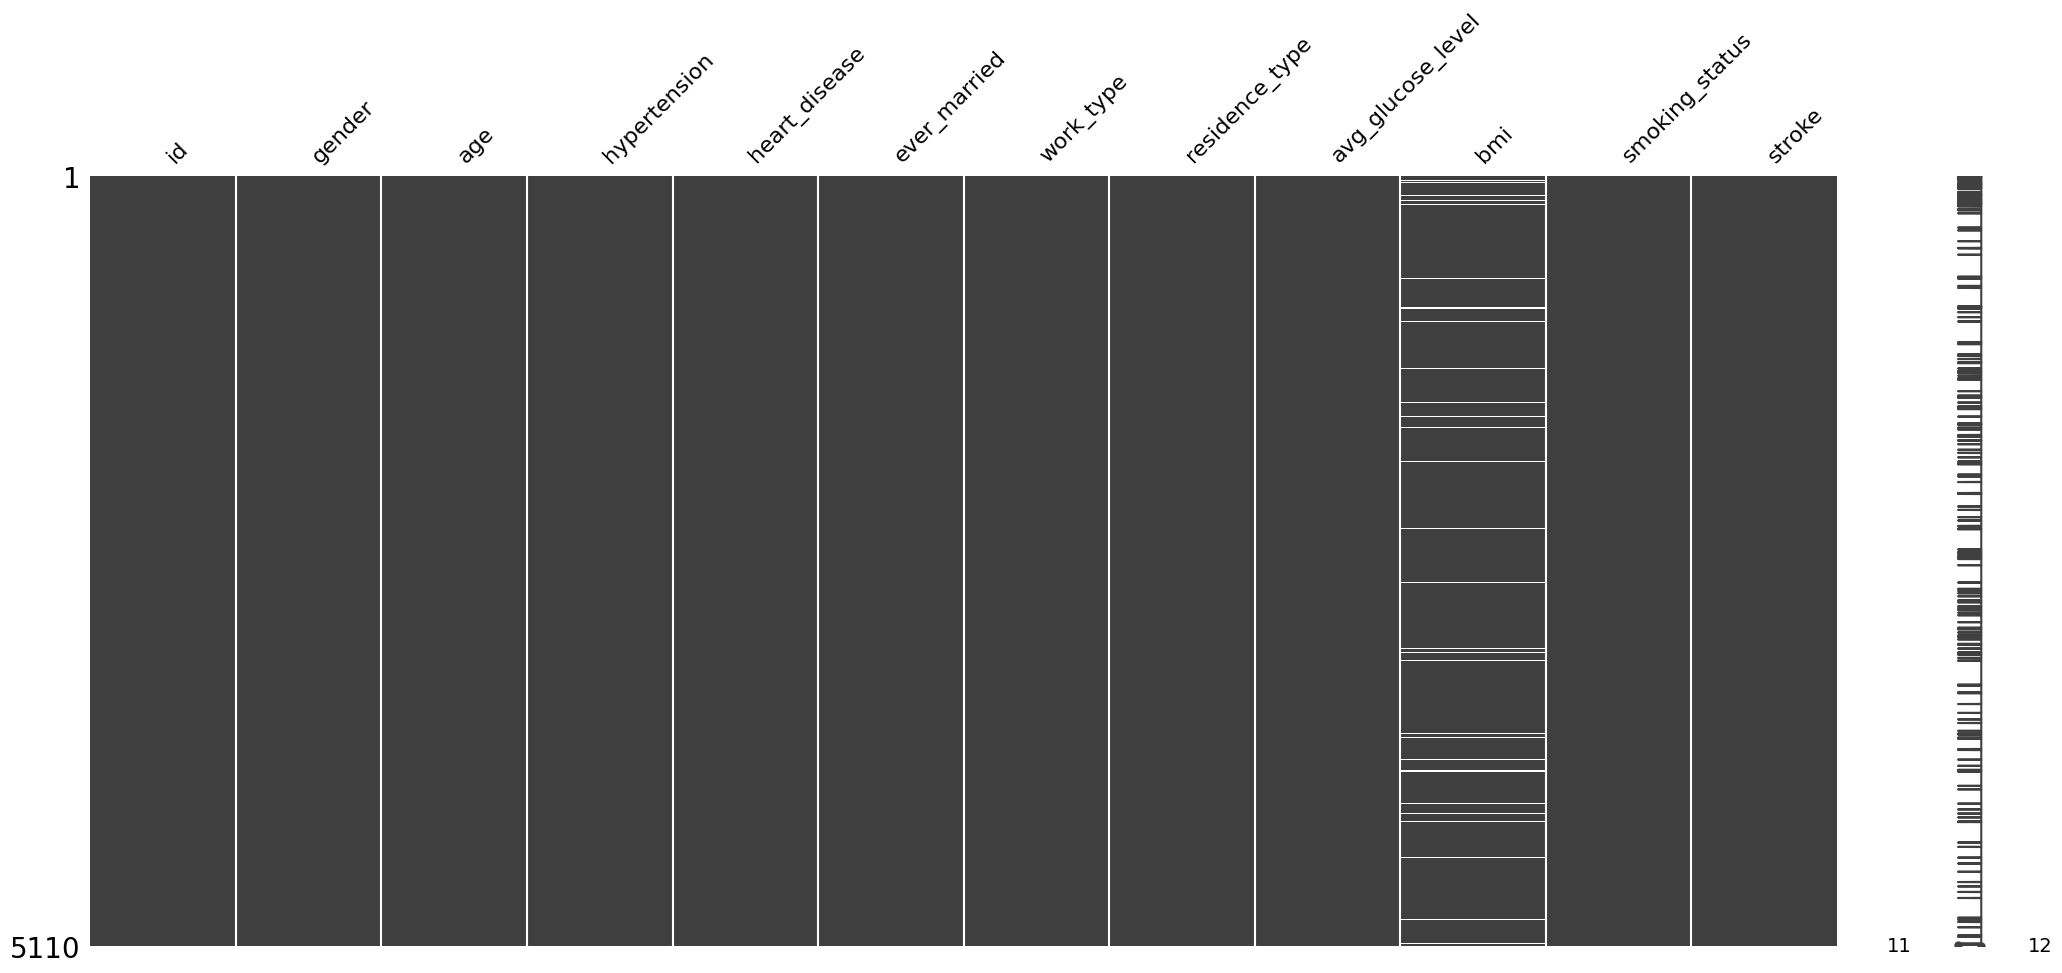

In [13]:
# Lets see if data is missing at random
msno.matrix(data)

<AxesSubplot: >

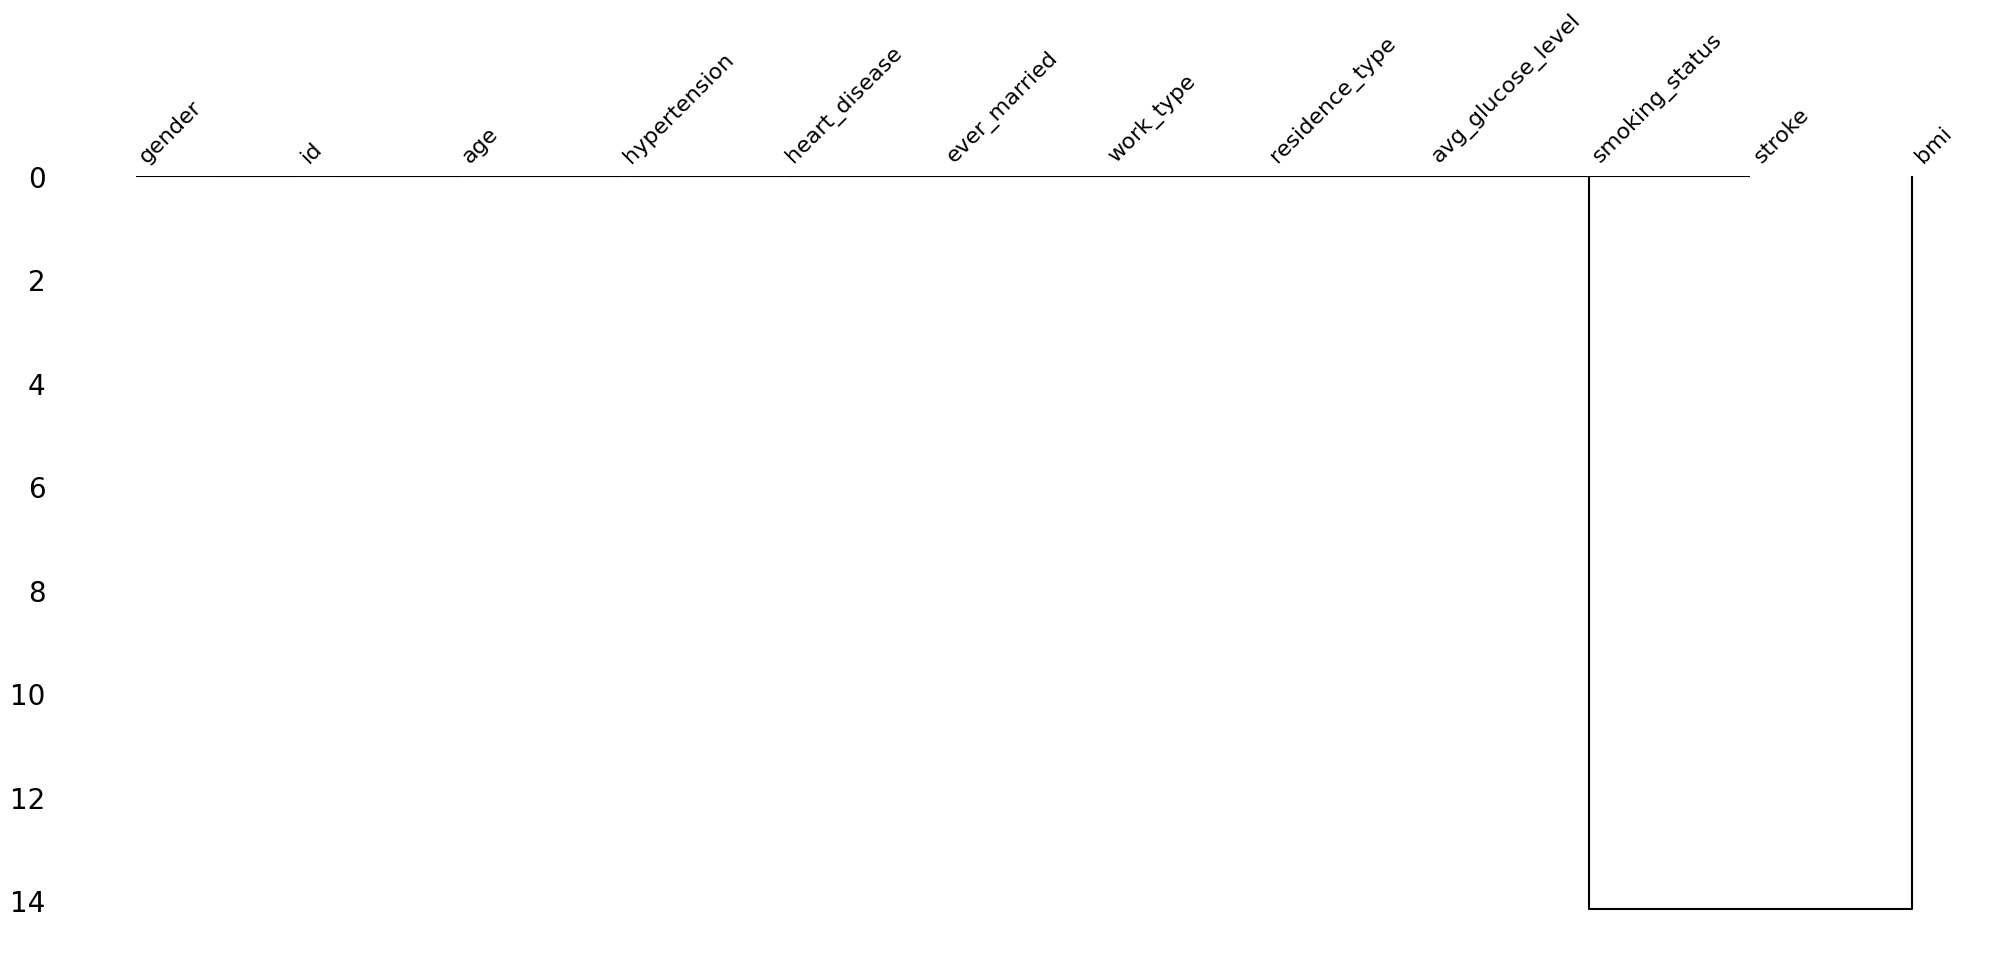

In [14]:
# Lets see the correlation plot
msno.dendrogram(data)

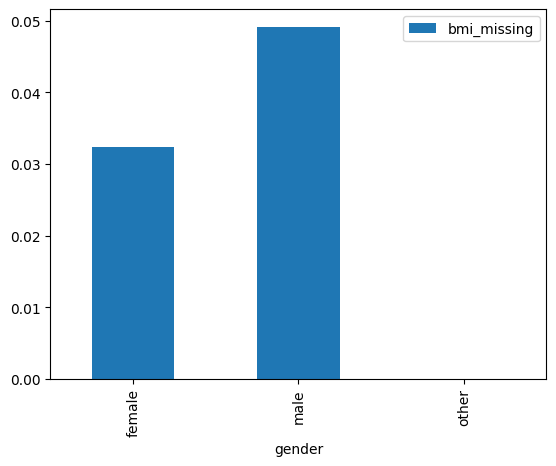

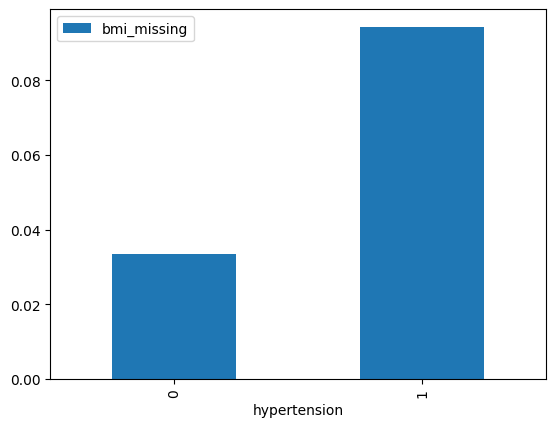

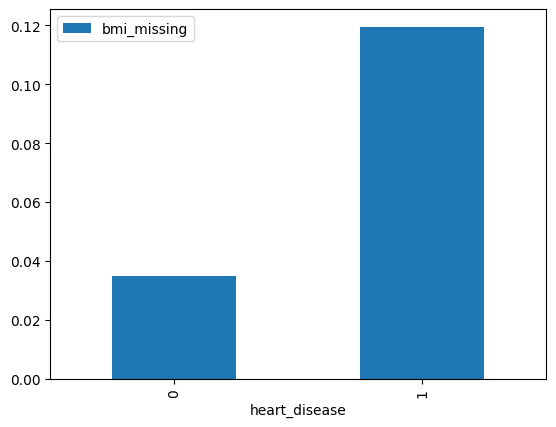

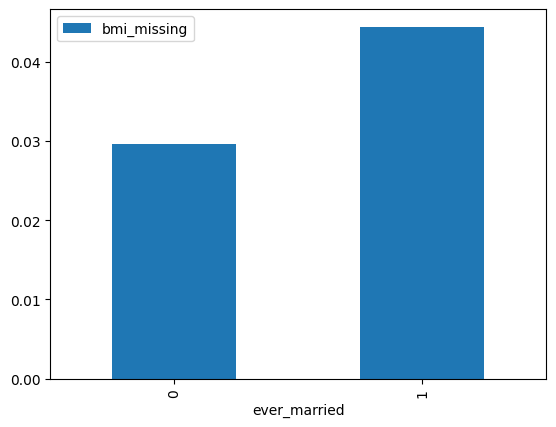

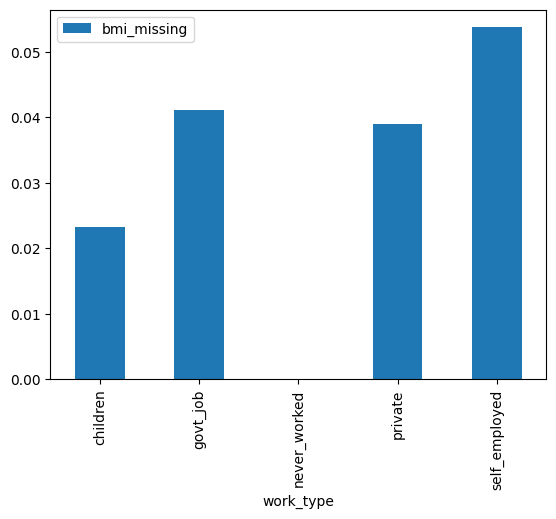

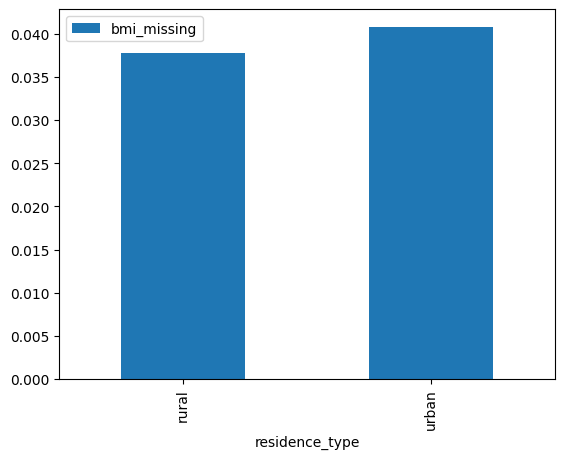

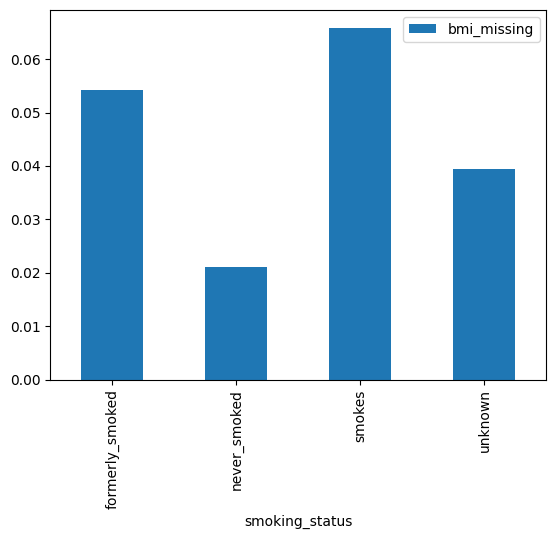

In [15]:
# This is suggesting that missingness in BMI is correlated with smoking status
data['bmi_missing'] = data['bmi'].isnull().astype(int)
for col in cat_columns:

    data.groupby([col]).agg({'bmi_missing':'mean'}).plot.bar()

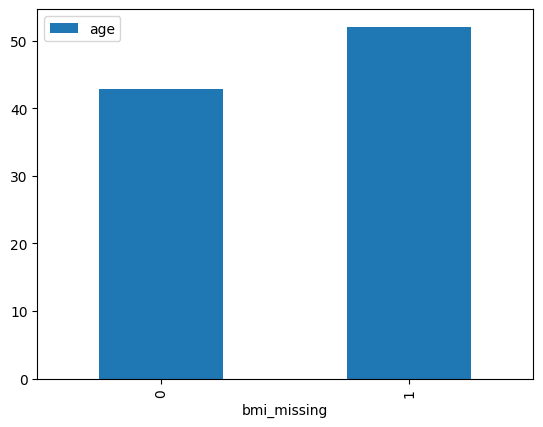

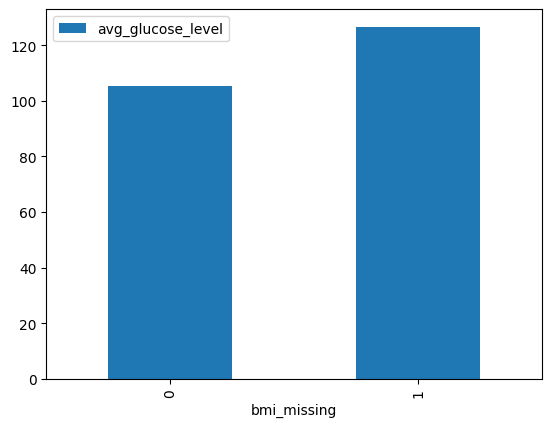

In [16]:
# Lets see if bmi missing is related to Numerical columns
num_cols = [cols for cols in data if cols not in [id, target, 'bmi', 'bmi_missing']+cat_columns]

for col in num_cols:
    data.groupby(['bmi_missing']).agg({col:'mean'}).plot.bar()

<AxesSubplot: xlabel='bmi_missing'>

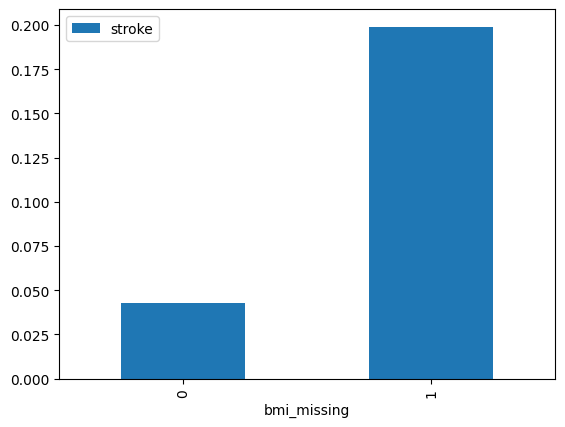

In [17]:
# Lets see if missing BMI information is correlated with the target
data['bmi_missing'] = data['bmi'].isnull().astype(int)
data.groupby(['bmi_missing']).agg({'stroke':'mean'}).plot.bar()

In [18]:
# This gives us enough information that missing data is not completely at random, but maybe missing at random, hence we can use other columns to help predict the value

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_9677/2668725999.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[cols for cols in data if cols not in  [id, 'bmi_missing']]].corr(), annot=True)


<AxesSubplot: >

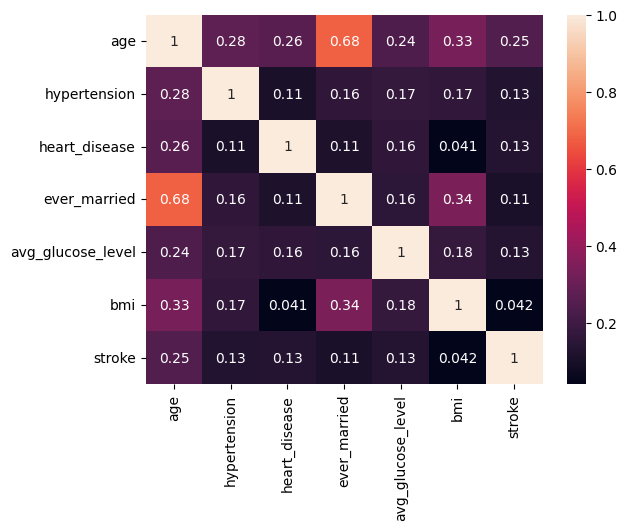

In [19]:
# Lets look at the correlation plots, and see if any numerical columns are correlated

sns.heatmap(data[[cols for cols in data if cols not in  [id, 'bmi_missing']]].corr(), annot=True)

In [20]:
# Now we can delete bmi_missing column
del data['bmi_missing']

In [21]:
# Now lets see how many people get the stroke
data[target].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [22]:
# Our dataset is highly imbalanced and in the entired dataset we have 5% chance that someone will have a stroke
global_stroke_rate = round(data[target].mean(),4)
global_stroke_rate

0.0487

In [23]:
# Building the feature importances
feature_importances = []
for cols in cat_columns:
    for idx in data[cols].unique():
        stroke_rate = round(data[data[cols] == idx][target].mean(),4)

        feature_importance = abs(global_stroke_rate - stroke_rate)
        risk_ratio = round(stroke_rate/global_stroke_rate,4)
        feature_importances.append([cols, idx, feature_importance, risk_ratio])


feature_importance_df = pd.DataFrame(data=feature_importances, columns=["feature", "sub_feature", "importance", "risk_ratio"])


In [24]:
# Printing the feature importance
feature_importance_df.sort_values(by='risk_ratio', ascending=False)

,feature,sub_feature,importance,risk_ratio
5,heart_disease,1,0.1216,3.4969
4,hypertension,1,0.0838,2.7207
10,work_type,self_employed,0.0307,1.6304
16,smoking_status,formerly_smoked,0.0304,1.6242
7,ever_married,1,0.0169,1.3470
18,smoking_status,smokes,0.0045,1.0924
14,residence_type,urban,0.0033,1.0678
0,gender,male,0.0024,1.0493
9,work_type,private,0.0022,1.0452
11,work_type,govt_job,0.0015,1.0308


In [25]:
# The feature importance abd risk ratio is suggesting us that heart disease and hypertension are high predictors of having a stroke
# Now lets get the mutual information

def mutual_information(data_series) -> float:

    return mutual_info_score(data_series, data[target])

mi = data[cat_columns].apply(mutual_information)
mi.sort_values(ascending=False)

ever_married      0.006950
work_type         0.006825
hypertension      0.005976
heart_disease     0.005897
smoking_status    0.002750
residence_type    0.000120
gender            0.000051
dtype: float64

In [26]:
#  The above shows that ever_married and work_type status are able to help explain stroke better

## Now we have understood the data, the next steps are getting the data ready for machine learning and making a machine learning pipeline